# About

- `Title:` "Learning relevant features of data with multi-scale tensor networks"
- `Main Author:` E. Miles Stoudenmire
- `Source:` [ArXiv](https://arxiv.org/abs/1801.00315)
- `Publish Date:` 31-12-2017
- `Reviewed Date:` 07-06-2021

## Citation

```latex
@article{stoudenmire2018learning,
  title={Learning relevant features of data with multi-scale tensor networks},
  author={Stoudenmire, E Miles},
  journal={Quantum Science and Technology},
  volume={3},
  number={3},
  pages={034003},
  year={2018},
  publisher={IOP Publishing}
}
```

# Install dependencies

In [1]:
!pip install -r requirements.txt --upgrade --quiet

# Notebook settings and imports

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import jax
import jaxlib
import jax.numpy as jnp

In [4]:
from typing import Tuple, NamedTuple,\
                   Optional, Iterable,\
                   Callable, List, Dict,\
                   Mapping, Any, Union

In [5]:
import os
import csv

In [6]:
import functools
import itertools
import operator

In [7]:
from sklearn import metrics

In [8]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

In [9]:
from timeit import default_timer as timer

# Random Seed

In [10]:
SEED = 31415

# Downloading the dataset

In [11]:
DATA_FOLDER = os.path.abspath('./data')

In [12]:
if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)

In [13]:
!wget -cN https://www.python-course.eu/data/mnist/mnist_train.csv -P {DATA_FOLDER}
!wget -cN https://www.python-course.eu/data/mnist/mnist_test.csv -P {DATA_FOLDER}

--2021-07-29 21:49:37--  https://www.python-course.eu/data/mnist/mnist_train.csv
Resolving www.python-course.eu (www.python-course.eu)... 138.201.17.115
Connecting to www.python-course.eu (www.python-course.eu)|138.201.17.115|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘/Users/aharol/Workspace/tensor-networks-algos/stoudenmire2018learning/data/mnist_train.csv’ not modified on server. Omitting download.

--2021-07-29 21:49:38--  https://www.python-course.eu/data/mnist/mnist_test.csv
Resolving www.python-course.eu (www.python-course.eu)... 138.201.17.115
Connecting to www.python-course.eu (www.python-course.eu)|138.201.17.115|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘/Users/aharol/Workspace/tensor-networks-algos/stoudenmire2018learning/data/mnist_test.csv’ not modified on server. Omitting download.



# Utilities

The utilities below are used used in defferent parts of the code.

## Sliding window

Sliding (aka rolling) window is a helper function to slice a data array using a window, not that 1D is a special case of 2D but has a simpler API, so I keep both.

In [14]:
def sliding_window_1D(A: jnp.ndarray, 
                      window: int,
                      step: Optional[int]=1
                     ) -> jnp.ndarray:
    """
    Sliding window iterator for 1D JAX arrays.
    """
    # Parameter
    m = A.size
    
    # Get starting indices
    start_idx = jnp.arange(0, m - window + 1, step)
    
    # Get offsetted indices
    offset_idx = jnp.arange(window)
    
    # Get all actual indices & index into input array for final output
    return jnp.take(A, start_idx[None,:] + offset_idx[:,None])


def sliding_window_2D(A: jnp.ndarray, 
                      window: Tuple[int,int], 
                      step: Tuple[int,int]=(1,1)
                     ) -> jnp.ndarray:   
    """
    Sliding window iterator for 2D JAX arrays.
    """
    # Parameters
    m,n = A.shape
    row_extent = m - window[0] + 1
    col_extent = n - window[1] + 1

    # Get starting block indices
    start_idx = jnp.arange(window[0])[:,None]*n + jnp.arange(window[1])

    # Get offsetted indices across the height and width of input array
    offset_idx = jnp.arange(0,row_extent,step[0])[:,None]*n + jnp.arange(0,col_extent,step[1])

    # Get all actual indices & index into input array for final output
    return jnp.take(A, start_idx.ravel()[:,None] + offset_idx.ravel())

In [15]:
A = jnp.arange(20)
assert jnp.allclose(sliding_window_1D(A, window=2, step=3), sliding_window_2D(A[None,:], window=(1,2), step=(1,3)))

## Convert array to tuple

In [16]:
def as_tuple(A: jnp.ndarray) -> Tuple:
    """Convert array into a tuple."""
    if isinstance(A, jnp.ndarray):
        return tuple(as_tuple(i) for i in A)
    else:
        return A

## Grouping

In [17]:
def group(seq: Iterable[Any], n: int):
    """Group a sequence into n groups."""
    return zip(*[iter(seq)]*n)

## Powers of two

The code below is required to determine the appropriate size of the initial tree. The paper assumes that the numpber of leaves of the the tree is some power of two.

In [18]:
def is_power_of_two(n: int) -> bool:
    """
    Check if a given number is a power of two.
    """
    return (n & (n-1) == 0) and n != 0

In [19]:
def power_of_two(n: int) -> Tuple[int, int]:
    """
    Given a number, returns it's previous 
    and next of keen which are powers of two.
    """
    if is_power_of_two(n):
        return n, n
    count = 0    
    while n != 0:
        n >>= 1
        count += 1
    prec = 1 << (count-1)
    succ = 1 << count
    return prec, succ

testing...

In [20]:
assert is_power_of_two(13)==False
assert is_power_of_two(28*28)==False
assert power_of_two(196) == (128, 256)

## Some linear algebra

In [21]:
def is_unitary(A: jnp.ndarray, rtol=1e-06, atol=1e-08) -> bool:
    """
    Check if the matrix is unitary.
    """
    I = jnp.eye(A.shape[0])
    cond1 = jnp.allclose(A @ A.conj().T, A.conj().T @ A, rtol=rtol, atol=atol)
    cond2 = jnp.allclose(A @ A.conj().T, I, rtol=rtol, atol=atol)
    return jnp.all(jnp.stack([cond1, cond2]))

In [22]:
def is_hermitian(A: jnp.ndarray, rtol=1e-06, atol=1e-08) -> bool:
    """
    Check if the matrix is Hermitian.
    """
    return jnp.allclose(A, A.conj().T, rtol=rtol, atol=atol)

In [23]:
def is_pd(A: jnp.ndarray) -> bool:
    """
    Check if a matrix is positive definite.
    """
    return jnp.all(jnp.linalg.eigvals(A) > 0)

In [24]:
def is_psd(A: jnp.ndarray) -> bool:
    """
    Check if a matrix is positive semidefinite.
    """
    return jnp.all(jnp.linalg.eigvals(A) >= 0)

In [25]:
def get_nearest_psd(A: jnp.ndarray) -> jnp.ndarray:
    """
    Get the nearest positive semidefinite matrix.
    The negative spectrum truncation is used.
    """
    C = (A + A.conj().T)/2
    p, U = jnp.linalg.eigh(C)
    p = p.at[jnp.where(p<0.0)].set(0)
    return  U @ (p * U.conj().T)

In [26]:
def get_nearest_pd(A: jnp.ndarray) -> jnp.ndarray:
    """
    Get the nearest positive definite matrix.
    The non-positive spectrum replacement is used.
    """
    C = (A + A.conj().T)/2
    p, U = jnp.linalg.eigh(C)
    p = p.at[jnp.where(p<=0.0)].set(1e-5)
    return  U @ (p * U.conj().T)

## Random matrices

In [27]:
def rand_mat(dim1: int, dim2: Optional[int] = None) -> jnp.ndarray:
    """
    Genarate a random matrix of size (dim1, dim2).
    If no second dimention is provided, a square matrix
    of size (dim1, dim1) is returned.
    """
    if not dim2:
        dim2 = dim1
    key = jax.random.PRNGKey(SEED)
    key, subkey = jax.random.split(key, 2)
    Re = jax.random.normal(key, shape=(dim1,dim2))
    Im = 1.j * jax.random.normal(subkey, shape=(dim1,dim2))
    return 2 * (Re + Im) - (1 + 1j)

In [28]:
def rand_unitary(dim: int) -> jnp.ndarray:
    """
    Random unitary matrix of dimention dim x dim
    http://home.lu.lv/~sd20008/papers/essays/Random%20unitary%20[paper].pdf
    """
    A = rand_mat(dim)
    Q,R = jnp.linalg.qr(A)
    r = jnp.diag(Q)
    L = jnp.diag(r/abs(r))
    return Q @ L

In [29]:
def rand_hermitian(dim: int) -> jnp.ndarray:
    """
    Generate random Hermitian matrix.
    """
    A = rand_mat(dim)
    return A + A.conj().T

In [30]:
def rand_psd(dim: int) -> jnp.ndarray:
    """
    Generate random Hermitian matrix.
    """
    A = rand_mat(dim)
    return A @ A.conj().T

testing...

In [31]:
A = rand_unitary(10)
assert is_unitary(A, atol=1e-6)

In [32]:
H = rand_hermitian(30)
assert is_hermitian(H)
assert not is_psd(H)

In [33]:
P = rand_psd(30)
assert is_psd(P)
assert is_hermitian(P)

## Curve Plotting

In [34]:
def use_svg_display():
    """
    Use the svg format to display a plot in Jupyter.
    """
    matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [35]:
def set_figsize(figsize=(3.5,2.5)):
    """
    Set the figure size for matplotlib.
    """
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

In [36]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """
    Set the axes for matplotlib.
    """
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [37]:
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5,2.5), axes=None,
         title=None):
    """
    Plot data points.
    """
    X = jnp.asarray(X)
    Y = jnp.asarray(Y)
    
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or
                isinstance(X, list) and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    axes.set_title(title)

## MNIST plotting

In [38]:
def show_img(img: jnp.ndarray, axes=None, title=None, figsize=(1.5,1.5)) -> None:
    """
    Shows a single image.
    """
    axes = axes if axes else plt.gca()
    set_figsize(figsize)
    axes.imshow(img, cmap='Greys')
    axes.set_xticks([])
    axes.set_yticks([])
    if title:
        axes.set_title(title, fontsize=9)

In [39]:
def show_img_grid(imgs: List[jnp.ndarray], 
                  titles: Iterable[str],
                  num_cols: Optional[int]=5
                 ) -> None:
    """
    Shows a grid of images.
    """
    n = len(imgs)
    assert n > 0, 'No data to display'
    
    num_rows = (n // num_cols)
    if n % num_cols > 0:
        num_rows += 1
    
    _, axes = plt.subplots(num_rows, num_cols)
    
    for i, (img, title) in enumerate(zip(imgs, titles)):
        if num_rows > 1:
            show_img(img, axes[i // num_cols][i % num_cols], title)
        else:
            show_img(img, axes[i % num_cols], title)
    
    # remove unused subplots
    for j in range(i % num_cols+1, num_cols):
        axes[i // num_cols, j].axis('off')

## Reading CSV helper

In [40]:
def read_csv(file_path: str, delimiter=',') -> List[Any]:
    """
    Read csv file.
    """
    with open(file_path, 'r') as f:
        reader = csv.reader(f, delimiter=delimiter)
        lines = [l for l in reader]
    return lines

## Time measurement

In [41]:
def exec_time(tic, toc: float) -> str:
    """
    Print execution time.
    """
    diff_time = toc - tic
    ms = diff_time
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    print('Execution Time: ' + f'{h:02d}:{m:02d}:{s:02d}:{ms:.4f}')

# Loading MNIST dataset

In [42]:
def load_mnist(data_path: str) -> Mapping[str, Mapping[str, jnp.ndarray]]:
    """
    Load MNIST digits dataset from CSV files.
    
    Input:
    ------
    data_path:  A path to the folder where to load the data from.
    
    Output:
    -------
    A dictionary containing the data set.
    """
    # data files
    train_data_path = os.path.join(data_path, 'mnist_train.csv')
    test_data_path = os.path.join(data_path, 'mnist_test.csv')

    # loading data
    train_data = read_csv(train_data_path, delimiter=',')
    test_data = read_csv(test_data_path, delimiter=',')
               
    # creating data
    train_data = jnp.asarray(train_data, dtype=jnp.float32)
    test_data = jnp.asarray(test_data, dtype=jnp.float32)

    # labels
    train_labels = train_data[:, :1].astype(jnp.int8)
    test_labels = test_data[:, :1].astype(jnp.int8)

    # scale between [0,1]
    frac = 1 / 255
    train_data = train_data[:, 1:] * frac
    test_data = test_data[:, 1:] * frac

    return {
        'train': {
            'images': train_data,
            'labels': train_labels,
        },
        'test': {
            'images': test_data,
            'labels': test_labels,
        }
    }

In [43]:
data = load_mnist(DATA_FOLDER)

In [44]:
assert jnp.allclose(jnp.stack([jnp.amin(data['train']['images']), 
                               jnp.amax(data['train']['images'])
                              ]),
                    jnp.array([0,1]))

Quickly checking that data is loaded correctly by plotting a set of image

In [45]:
assert (jnp.unique(data['train']['labels']) == jnp.arange(10)).all().item()

In [46]:
assert jnp.allclose(jnp.stack([jnp.amin(data['test']['images']), 
                               jnp.amax(data['test']['images'])
                              ]),
                    jnp.array([0,1]))

In [47]:
assert (jnp.unique(data['test']['labels']) == jnp.arange(10)).all().item()

Quickly checking that data is loaded correctly by plotting a set of image

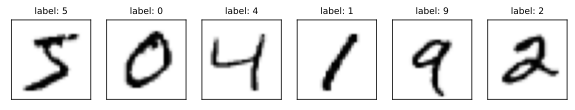

In [48]:
set_figsize((10,4))

show_img_grid(
    [data['train']['images'][i].reshape(28,28) for i in range(6)],
    [f"label: {data['train']['labels'][i].item()}" for i in range(6)],
    num_cols=6
)

# Process images

One needs to rescale images so the size of each image is a power of $2$. This is required for the algorithm to work and could be seen as a drawback. 

The are two options to rescale:
1. **Downscaling** the image may reduce the time required to train the tensor network model, but also has a drawback as it removes necessary information by reduction. 
2. **Upscaling** works in the opposit way. 
Which way to choose depends on a particular situation.

First, I determine the nearest powers of $2$ given the size of each image.

In [49]:
img_vec = data['train']['images'][0]  # take an image
size = jnp.sqrt(img_vec.size).astype(int)
size_l, size_h = power_of_two(size)   # returns nearest powers of 2 (low and high)

print(f'The nearest powers of two are: {size_l} and {size_h}.')

The nearest powers of two are: 16 and 32.


The paper does not specifically say about this aspect, so I decide to downscale the image to $16 \times 16$ pixels, so the training is running a bit faster.

In [50]:
def resize(img_vec: jnp.ndarray, shape: Tuple[int,int]) -> jnp.ndarray:
    """
    Resizing the image vector.
    """
    orig_size = jnp.sqrt(img_vec.size).astype(int)
    img = img_vec.reshape(orig_size, orig_size)
    img = jax.image.resize(img, shape, method='linear')
    return img.reshape(-1,1)

In [51]:
# new_shape = (28,28)
new_shape = (16,16)

In [52]:
# vectorized version of the resise
vresize = jax.vmap(functools.partial(resize, shape=new_shape))

In [53]:
train_images = jnp.squeeze(vresize(data['train']['images']))
test_images = jnp.squeeze(vresize(data['test']['images']))

In [54]:
train_images.shape, test_images.shape

((60000, 256), (10000, 256))

Checking if data is scaled properly by plotting random digits...

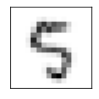

In [55]:
set_figsize((1.5,1.5))

j = 41312
show_img(train_images[j].reshape(new_shape))

# Feature map

The feature map $\Phi(\bf x)$ maps inpunt data vector $\bf x$ from a space of dimension $N$ to a space of dimension $d^N$, i.e. each component of the input vector $x_j$ is mapped into a $d$-dimensional vector. See Eq. 8 in text for details. We are interested in small $d$.

In [56]:
features = [
    lambda _: 1,
    lambda x: x,
]

feature extraction...

In [57]:
train_data = jnp.stack([jax.vmap(jax.vmap(f))(train_images.T) for f in features])
test_data = jnp.stack([jax.vmap(jax.vmap(f))(test_images.T) for f in features])

In [58]:
train_data.shape, test_data.shape

((2, 256, 60000), (2, 256, 10000))

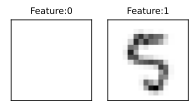

In [59]:
j = 41312     
img = train_data[:,:,j]

set_figsize((3.2,4.2))

_, axs = plt.subplots(1, len(features), sharey=True)
for i in range(len(features)):
    show_img(img[i,:].reshape(new_shape), 
             axs[i], 
             title=f'Feature:{i}')

## Normalizing features

In [60]:
def normalize_along_axis(A: jnp.ndarray, 
                         ord: Optional[int]=2,
                         axis: Optional[int]=0) -> jnp.ndarray:
    """
    Normalizing the input axis along the given axis.
    
    Input:
    ------
    A:    Input tensor.
    ord:  The order of the norm used (Default: 2)
    axis: The axis along which to normalize.
    
    Output:
    -------
    The normalized tensor.
    """
    Z = jnp.atleast_1d(jnp.linalg.norm(A, ord, axis))
    Z = Z.at[jnp.where(Z==0.0)].set(1.0)
    return A / jnp.expand_dims(Z, axis)

In [61]:
train_data = normalize_along_axis(train_data, axis=0)
test_data = normalize_along_axis(test_data, axis=0)

checking on random sample...

In [62]:
sample_size = 100

key = jax.random.PRNGKey(SEED)
key1, key2 = jax.random.split(key, 2)

for i in range(sample_size):
    m = jax.random.choice(key1, train_data.shape[1]) # random feature
    n = jax.random.choice(key2, train_data.shape[2]) # random image
    assert jnp.allclose(train_data[:,m,n].T @ train_data[:,m,n], 1)
    assert jnp.allclose(test_data[:,m,n].T @ test_data[:,m,n], 1)

Checking again if images are correctly processed...

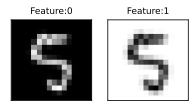

In [63]:
j = 41312     
img = train_data[:,:,j]

set_figsize((3.2,4.2))

_, axs = plt.subplots(1, len(features), sharey=True)
for i in range(len(features)):
    show_img(img[i,:].reshape(new_shape), 
             axs[i], 
             title=f'Feature:{i}',
            )

## Rearranging axis for convenience

Because JAX preferes leading axes, I rearrange the data axes.

In [64]:
train_data = train_data.transpose(1,0,2)
test_data = test_data.transpose(1,0,2)

In [65]:
train_data.shape, test_data.shape

((256, 2, 60000), (256, 2, 10000))

# Learning the Tree Tensor Network

## The reduced covariance matrix and a truncation point

In [66]:
@jax.jit
def suggest_truncation(
        A: jnp.ndarray, 
        tol: Optional[float]=1e-3
        ) -> Tuple[jnp.ndarray, jnp.ndarray, int]:
    """
    Suggest a truncation index of the spectrum 
    to approximate the input covariance matrix.
    The truncation point satisfies the condition:
    sum(p)/trace(a) < eps.

    Input:
    ------
    A:      Matrix to be truncated (must be Hermitian).
    tol:    The allowed truncation error.

    Output:
    -------
    p:      The spectrum (eigenvalues) in increasing order.
    U:      The corresponding eigenvectors.
    idx:    The suggested index corresponding to the tol.
    """
    p, U = jnp.linalg.eigh(A)
    err = jnp.cumsum(p / jnp.trace(A))
    idx = jnp.searchsorted(err, tol)
    return p, U, idx

quickly checking

In [67]:
A = rand_hermitian(100)

p, U, idx = suggest_truncation(A, tol=1e-6)
jnp.allclose((U[:,idx:] * p[idx:]) @ U[:,idx:].conj().T, A, atol=1e-5) 

DeviceArray(True, dtype=bool)

Also, checking the behavior of truncation on a set of cutoff points.

In [68]:
# random covariance matrix
A = rand_psd(100)

tols = [0.5**x for x in range(10)]
err = []
indices = []
for tol in tols:
    p,U,idx = suggest_truncation(A, tol=tol)
    Aᵟ = (U[:,idx:] * p[idx:]) @ U[:,idx:].conj().T
    Δ = jnp.abs(jnp.trace(A-Aᵟ))
    err.append(Δ)
    indices.append(idx)

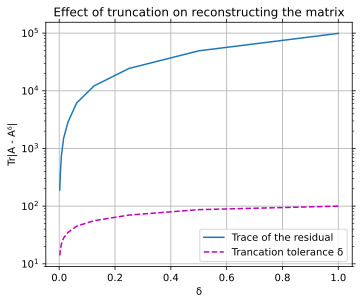

In [69]:
plot(tols, [err, indices], 
     xlabel='δ', ylabel='Tr|A - Aᵟ|', 
     legend=['Trace of the residual', 'Trancation tolerance δ'],
     figsize=(5.5,4.5),
     yscale='log',
     title='Effect of truncation on reconstructing the matrix'
)

## The protocol

To start, I introduce the tree data structure. This should accumulate the isometries as the algorithm keep building the tree recursively.

In [71]:
class Tree:
    
    def __init__(self, 
                 window_agg_pattern,
                 projection_agg_pattern,
                 window_size=(1,2),
                 window_step=(1,2),
                 max_bond=250,
                 tol=1e-2,
                 verbose=False):
        """
        The tree tensor network.
        """
        self.window_agg_pattern = window_agg_pattern
        self.projection_agg_pattern = projection_agg_pattern
        self.window_size = window_size
        self.window_step = window_step
        self.max_bond = max_bond
        self.tol = tol
        self.verbose = verbose
        self.layers = []
        
    def truncate(self, tensor: jnp.ndarray) -> jnp.ndarray:
        """        
        Truncate the input tensor and reshape
        approprietely as the the heavy lifting
        is happening in a jitted subroutine.
        The actual slicing, on the other hand,
        is happening here.
        """
        m, n, *_ = tensor.shape
        matrix = tensor.reshape(m * n, -1)
        # symmetrize if not perfectly symmetric
        matrix = (matrix + matrix.conj().T) / 2
        _, isometry, idx = suggest_truncation(matrix, self.tol)
        if idx == m * n:
            # nothing to cut
            result = isometry
        elif m * n - self.max_bond <= idx:
            # soft cut
            result = isometry[:,idx:]
        else:
            # hard cut
            result = isometry[:, -self.max_bond:]
        return result.reshape(m, n, -1)
        
    def _get_reduced_densities(self, state):
        """
        Calculate the reduced dencities of a 2D state.
        """
        # getting the shape of the input state
        state_flat, state_def = jax.tree_util.tree_flatten(state)
        
        # shape of the input state
        n = state_def.num_leaves
        m = len(state_def.children())
        shape = (m, n//m)
        
        # getting the indices to aggregate
        indices = jnp.arange(n).reshape(shape)  # indices as lattice
        agg_idx = sliding_window_2D(indices, self.window_size, self.window_step)
        
        # precomputes all density matrices
        rhos = jax.tree_map(
            lambda x: jnp.einsum(
                'ij,kj->ikj', x, x.conj()
            ), 
            state_flat
        )

        # computing reduced densities
        rho_ij = jax.tree_map(
            lambda *idx: jnp.einsum(
                self.window_agg_pattern, *(rhos[i] for i in idx)
            ),
            *as_tuple(agg_idx)
        )

        return rho_ij
    
    def _project(self, state, isometries, *other_isometries):
        """
        A projector of input state onto the tree.
        Also used to produce the input for the next layer
        of the isometries tree.
        """
        # getting the tree shape
        state_flat, state_def = jax.tree_util.tree_flatten(state)

        # getting the tree shape
        n = state_def.num_leaves
        m = len(state_def.children())
        shape = (m, n//m)
        
        # getting the indices to aggregate
        indices = jnp.arange(n).reshape(shape)  # indices as lattice
        agg_idx = sliding_window_2D(indices, self.window_size, self.window_step)
        
        # actual projection and new tree definition
        new_state_flat = jax.tree_multimap(
            lambda isometry, *idx: jnp.einsum(
                self.projection_agg_pattern,
                isometry,
                *(state_flat[i] for i in idx)
            ),
            isometries,
            *as_tuple(agg_idx), 
        )

        # size of new state
        new_size = (m-self.window_size[1])//self.window_step[1] + 1
        new_state = tuple(group(new_state_flat, new_size))
        
        if other_isometries:
            return self._project(new_state, *other_isometries)
        else:
            return new_state
        
    def project(self, state):
        return self._project(state, *self.layers)
        
    def build(self, state):
        """
        Main routine to build a tree of isometries.
        State is a PyTree of JAX arrays.
        """
        size = len(sum(state,()))
        
        if self.verbose:
            in_dim = jnp.array(jax.tree_map(lambda s: s.shape[0], state))
            max_dim = jnp.max(in_dim).item()  # max value over all
            print(f'Total state size: {size}\tMax dimension: {max_dim}')

        # this is the number of sites of the tree to stop
        if size == 2:
            return state

        # calculate the reduced density matrices
        rho_ij = self._get_reduced_densities(state)

        # truncate isometries
        new_isometries = jax.tree_map(self.truncate, rho_ij)

        self.layers.append(new_isometries)
        
        # defining a new state
        new_state = self._project(state, new_isometries)
        
        return self.build(new_state)

In [100]:
tree = Tree(
    window_agg_pattern='ikj,mnj->imkn',
    projection_agg_pattern='mnk,mj,nj->kj',
    window_size=(1,2),
    window_step=(1,2),
    max_bond=300,
    tol=2e-2,
    verbose=True)

In [101]:
n,m = new_shape
phi_train = tuple(group(tuple(train_data), m))
phi_test = tuple(group(tuple(test_data), m))

In [ ]:
tic = timer()
train_tn = tree.build(phi_train)
exec_time(tic,timer())

Total state size: 256	Max dimension: 2
Total state size: 128	Max dimension: 3
Total state size: 64	Max dimension: 5
Total state size: 32	Max dimension: 6
Total state size: 16	Max dimension: 15
Total state size: 8	Max dimension: 56
Total state size: 4	Max dimension: 300


In [ ]:
test_tn = tree.project(phi_test)

# Classifying digits

## The conjugate gradient algorithm implementation

I want to follow the paper as close as possible (and also learn something along the line). So, I have decided to implement a custom conjugate gradient descent algorithm that the paper is using as well.

In [ ]:
compose_conditionals = lambda *F:  functools.reduce(
    lambda f, g: lambda x: f(x) & g(x), F)

class Params(NamedTuple):
    s: int  # current step
    r: jnp.ndarray
    x: jnp.ndarray
    d: jnp.ndarray

def update(A: jnp.ndarray, params: Params) -> Params:
    """
    The update step for the CG optimization.
    """
    s,r,x,d = params    
    r2 = r.conj().T @ r
    Ad = A @ d
    alpha = r2 / (d.conj().T @ Ad)
    x = x + (alpha * d)
    r = r + (alpha * Ad)
    beta = (r.conj().T @ r) / r2
    d = -r + (beta * d)
    s += 1
    return Params(s,r,x,d)

def init(A, b: jnp.ndarray) -> Params:
    """
    Parameters initializer.
    """
    x = jnp.ones_like(b)
    r = (A @ x) - b
    d = -r
    return Params(0,r,x,d)

@jax.jit
def conjugate_gradient(A, b, max_steps=int(1e+5), tol=1e-6):
    """
    Main routing to execute the CG optimization.
    
    Input:
    ------
    A:          A nxn psd matrix.
    b:          A nx1 vector.
    max_steps:  A maximum number of steps to run.
    tol:        A minimal tolerance on the norm of the residial (Ax-b).

    Output:
    -------
    The solution nx1 vector.
    """
    cond_max_steps = lambda params: params.s < max_steps
    cond_max_norm = lambda params: jnp.linalg.norm(params.r) > tol
    cond_fun = lambda params: compose_conditionals(cond_max_steps, cond_max_norm)(params)
    body_fun = functools.partial(update, A)
    params0 = init(A, b)
    params = jax.lax.while_loop(cond_fun, body_fun, params0)
    return params.x

Testing it on a randomly generated dataset.

In [ ]:
key = jax.random.PRNGKey(SEED)
key1, key2 = jax.random.split(key, 2)

n = 100
A = rand_psd(n)
b = jax.random.normal(key1, (n,1)) +\
    1j * jax.random.normal(key2, (n,1))

In [ ]:
x = conjugate_gradient(A, b)
jnp.allclose(A @ x, b, atol=1e-2)

## Preparing the data

In [ ]:
X_train = jnp.vstack(sum(train_tn,())).T
X_test = jnp.vstack(sum(test_tn,())).T

In [ ]:
y_train = jnp.squeeze(data['train']['labels'])
y_test = jnp.squeeze(data['test']['labels'])

In [ ]:
# number of digits
n_digits = jnp.unique(y_train).size
# one-hot encoding for OvA
y_train_one_hot = jax.nn.one_hot(y_train, num_classes=n_digits)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

## Train a OvA classifier using CGD

### Training

In [ ]:
@jax.jit
def train_bin(X, y: jnp.ndarray) -> jnp.ndarray:
    """
    Train a binary classifier.
    """
    m,_ = X.shape
    # adding bias term
    I = jnp.ones(shape=(m,1), dtype=jnp.float32)
    X = jnp.hstack([I, X])
    Z = (X.T @ X)
    q = X.T @ y
    w = conjugate_gradient(Z, q)
    return w

@jax.jit
def train_ova(X, y: jnp.ndarray) -> jnp.ndarray:
    """
    Train a matrix of weights using OvA strategy.
    """
    return jax.vmap(train_bin, in_axes=(None, 1), out_axes=0)(X, y)

In [ ]:
W = train_ova(X_train, y_train_one_hot)

### Prediction

In [ ]:
@jax.jit
def predict_bin(X, w: jnp.ndarray) -> jnp.ndarray:
    m,_ = X.shape
    # adding bias term
    I = jnp.ones(shape=(m,1), dtype=jnp.float32)
    X = jnp.hstack([I, X])
    return X @ w

@jax.jit
def predict_ova(X, W: jnp.ndarray) -> jnp.ndarray:
    """
    Predict labels given classifier weights.
    """
    return jnp.argmax(
               jax.vmap(predict_bin, 
                        in_axes=(None, 0), 
                        out_axes=0
                       )(X, W),
               axis=0)

In [ ]:
y_pred = predict_ova(X_test, W)

In [ ]:
print(f'Classification report for OvA classifier CG:\n\n'
      f'{metrics.classification_report(y_test, y_pred)}\n')

In [ ]:
print(f'Classification confusion matrix:\n\n'
      f'{metrics.confusion_matrix(y_test, y_pred)}\n')

## Training on the original data

In [ ]:
X_train_orig = train_images
X_test_orig = test_images

In [ ]:
W_orig = train_ova(X_train_orig, y_train_one_hot)

In [ ]:
y_pred_orig = predict_ova(X_test_orig, W_orig)

In [ ]:
print(f'Classification report for OvA classifier CG:\n\n'
      f'{metrics.classification_report(y_test, y_pred_orig)}\n')

In [ ]:
print(f'Classification confusion matrix:\n\n'
      f'{metrics.confusion_matrix(y_test, y_pred_orig)}\n')

# Sandbox

In [ ]:
# Tree = Union[jnp.ndarray, Tuple[jnp.ndarray]]
# TreeDef = jaxlib.xla_extension.PyTreeDef

In [ ]:
# def truncate(A: jnp.ndarray, 
#              max_bond: Optional[int]=200, 
#              tol: Optional[float]=1e-3
#              ) -> jnp.ndarray:
#     """
#     This is just a helper function to
    
#     truncate the input tensor and reshape
#     approprietely as the the heavy lifting
#     is happening in a jitted subroutine.
#     The actual slicing, on the other hand,
#     is happening here.
#     """
#     m, n, *_ = A.shape
#     C = A.reshape(m * n, -1)
#     # symmetrize if not perfectly symmetric
#     C = (C + C.conj().T) / 2
#     _, U, idx = suggest_truncation(C, tol)
#     if idx == m * n:
#         # nothing to cut
#         result = U
#     elif m * n - max_bond <= idx:
#         # soft cut
#         result = U[:,idx:]
#     else:
#         # hard cut
#         result = U[:, -max_bond:]
#     return result.reshape(m, n, -1)

In [ ]:
# def get_reduced_densities(tree_flat: Tree,
#                           tensors_agg_pat: str,
#                           agg_idx: jnp.ndarray
#                          ) -> Tree:
#     """
#     Calculate the reduced dencities.
#     Input:
#     ------
#     tree_flat:         The pytree of input tensors (flat!). 
#     tensors_agg_pat:   A pattern specifying coarse graining
#                        pattern (must comply with einsum).
#     agg_idx:           An array where each collumn specifies
#                        which tree indices go into a single
#                        atomic coarse graining step.
                       
#     Outpus:
#     -------
#     Reduced densities.
#     """      
#     # precomputes all density matrices
#     rhos = jax.tree_map(
#         lambda x: jnp.einsum(
#             'ij,kj->ikj', x, x.conj()
#         ), 
#         tree_flat
#     )
    
#     # computing reduced densities
#     rho_ij = jax.tree_map(
#         lambda *idx: jnp.einsum(
#             tensors_agg_pat, *(rhos[i] for i in idx)
#         ),
#         *as_tuple(agg_idx)
#     )
    
#     return rho_ij

In [ ]:
# def project(tree: Tree,
#             project_agg_pat: str,
#             window,
#             step,
#             isoms: Tree, 
#             *other: Tree
#            ) -> Tree:
#     """
#     A projector of input tree onto the isometries.
#     Used to produce the input for the next layer
#     of the isometries tree.
#     """
#     # getting the tree shape
#     tree_flat, tree_def = jax.tree_util.tree_flatten(tree)
    
#     # getting the tree shape
#     n = tree_def.num_leaves
#     m = len(tree_def.children())
#     tree_shape = (n//m, m)

#     # getting the indices to aggregate
#     indices = jnp.arange(n).reshape(tree_shape)  # indices as lattice
#     agg_idx = sliding_window_2D(indices, window, step)
    
#     # actual projection and new tree definition
#     new_tree_flat = jax.tree_multimap(
#         lambda isom, *idx: jnp.einsum(
#             project_agg_pat,
#             isom,
#             *(tree_flat[i] for i in idx)
#         ),
#         isoms,
#         *as_tuple(agg_idx), 
#     )
    
#     new_tree = tuple(group(new_tree_flat, m // window[1]))
# #     # propagating the site when the tree length is odd
# #     if bool(n%2):
# #         new_tree = new_tree + (tree[-1],)

#     if other:
#         import pdb; pdb.set_trace()
#         return project(new_tree, project_agg_pat, window, step, *other)
#     else:
#         return new_tree

In [ ]:
# def build_tree(tree: Tree,
#                tensors_agg_pat,
#                project_agg_pat,
#                window,
#                step,
#                tol: Optional[float]=1e-3,
#                max_bond: Optional[int]=200,
#                verbose: Optional[bool]=False
#               ) -> Iterable[Tree]:
#     """
#     Main routine to build a tree of isometries.
    
#     Input:
#     ------
#     tree:               Input tree (JAX pytree data structure).
#     tol:                Tolerance used to cut truncate the isometries.
#     max_bond:           The maximum bond dimension allowed 
#                         (largely depend on the coputing hardware).
#     verbose:            Flag to spit out prints during construction.
    
#     Output:
#     A iterable with isometries at each level.
#     """
    
#     # getting the tree shape
#     tree_flat, tree_def = jax.tree_util.tree_flatten(tree)
    
#     # getting the tree shape
#     n = tree_def.num_leaves
#     m = len(tree_def.children())
#     tree_shape = (n//m, m)
    
#     if verbose:
#         in_dim = jnp.array(jax.tree_map(lambda x: x.shape[0], tree_flat))
#         print(f'Tree width: {n}\tMax dimension: {in_dim.max().item()}')

#     if n == 2: 
#         return
    
#     # getting the indices to aggregate
#     indices = jnp.arange(n).reshape(tree_shape)  # indices as lattice
#     #agg_idx = indices_agg_fun(indices)           # aggregation
#     agg_idx = sliding_window_2D(indices, window, step)
        
#     # calculate the reduced density matrices
#     rho_ij = get_reduced_densities(tree_flat, tensors_agg_pat, agg_idx)
    
#     # truncated (approximated) isometries
#     isoms = jax.tree_map(
#         functools.partial(truncate, max_bond=max_bond, tol=tol), 
#         rho_ij
#     )

#     return isoms
    
#     # defining a new tree
#     new_tree = project(tree, project_agg_pat, window, step, isoms)
    
#     yield from build_tree(new_tree,
#                           tensors_agg_pat=tensors_agg_pat,
#                           project_agg_pat=project_agg_pat,
#                           window=window,
#                           step=step,
#                           tol=tol, 
#                           max_bond=max_bond, 
#                           verbose=verbose)

In [ ]:
# converting the ndarray to a tuple (aka pytree)
# phi_train = jax.tree_map(jnp.asarray, tuple(train_data))
# phi_test = jax.tree_map(jnp.asarray, tuple(test_data))

* The tensor aggregation function specifies how one combines tensor during coarse grainig. 
* Projection aggregation function specifies how one project tensors onto the isometries.

In [ ]:
# tensors_agg_pat = 'ikj,mnj->imkn'  # means two tensors of order 3 are combined into a tensor of order 4
# project_agg_pat = 'mnk,mj,nj->kj'  # means two tensors of order 2 are projected onto a tensor of order 3
#                                    # resulting in a tensor of order 2

The maximum bond dimension can improve the accuracy, but also increases the dimensionality of the dataset used for the downstream classification.

In [ ]:
# n,m = new_shape
# phi_train = tuple(group(tuple(train_data), m))
# phi_test = tuple(group(tuple(test_data), m))

In [ ]:
# tree_iterator = build_tree(
#     tree=phi_train,
#     tensors_agg_pat=tensors_agg_pat,
#     project_agg_pat=project_agg_pat,
#     window=(1,2),
#     step=(1,2),
#     max_bond=200, 
#     tol=5e-2, 
#     verbose=True,
#     )

In [ ]:
# tree_iterator1, tree_iterator2 = itertools.tee(tree_iterator, 2)

Below is the training...

In [ ]:
# tic = timer()
# train_tn = project(phi_train, *tree_iterator1)
# toc = timer()
# exec_time(tic,toc)

In [ ]:
# test data projection
# test_tn = project(phi_test, *tree_iterator2)

In [ ]:
# jax.tree_map(jnp.shape, train_tn), jax.tree_map(jnp.shape, test_tn)